## 1. Upload i przetworzenie daych

In [772]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
df = fetch_openml(data_id = 31) 
y = df.target
X = df.data
print("Nans?: %s %s, X Shape: %s , y shape: %s, X columns: \n %s" % (X.isna().any().any(), y.isna().any().any(), X.shape, y.shape, X.columns))
X.head()

Nans?: False False, X Shape: (1000, 20) , y shape: (1000,), X columns: 
 Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker'],
      dtype='object')


/Users/janpoglod/opt/anaconda3/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes


In [341]:
print("Macierz kowariancji:")
X.corr()

Macierz kowariancji:


,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
duration,1.000000,0.624984,0.074749,0.034067,-0.036136,-0.011284,-0.023834
credit_amount,0.624984,1.000000,-0.271316,0.028926,0.032716,0.020795,0.017142
installment_commitment,0.074749,-0.271316,1.000000,0.049302,0.058266,0.021669,-0.071207
residence_since,0.034067,0.028926,0.049302,1.000000,0.266419,0.089625,0.042643
age,-0.036136,0.032716,0.058266,0.266419,1.000000,0.149254,0.118201
existing_credits,-0.011284,0.020795,0.021669,0.089625,0.149254,1.000000,0.109667
num_dependents,-0.023834,0.017142,-0.071207,0.042643,0.118201,0.109667,1.000000


Uzycie funkcji get_dummies aby zamienić zmienne kategoryczne na numeryczne. Usuwam w kadej zmiennej jedną kategorię bo jest ona zalena od pozostałych

In [774]:
X = pd.get_dummies(X, columns=["purpose","checking_status","credit_history","savings_status","employment","personal_status","other_parties","property_magnitude","other_payment_plans","housing","job","own_telephone","foreign_worker"], drop_first=True)
X.shape
y = y.replace({"good":1,"bad":0})

## 2.1 Model Regresji logistycznej

Bez kroswalidacji

In [776]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=320575)
lm = LogisticRegression(penalty=None, max_iter=1000)
lm.fit(X_train, y_train)

LogisticRegression(max_iter=1000, penalty=None)

In [777]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, roc_curve, precision_score
y_pred_lm = lm.predict(X_test)
y_predict_proba_lm = lm.predict_proba(X_test)
print("Accuracy score: %0.4f\nRecall score: %0.4f\nRoc Auc score: %0.4f" % (accuracy_score(y_test, y_pred_lm), recall_score(y_test, y_pred_lm), roc_auc_score(y_test, y_predict_proba_lm[:,1])))
print(f"Precision Score = {np.round(precision_score(y_test, y_pred_lm),4)}")

Accuracy score: 0.7375
Recall score: 0.8796
Roc Auc score: 0.7814
Precision Score = 0.77


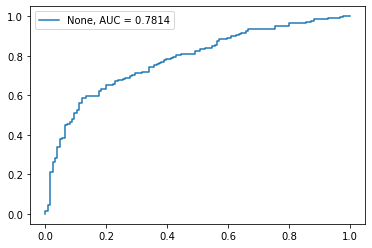

In [778]:
import matplotlib.pyplot as plt
fpr, tpr, tresholds = roc_curve(y_test, y_predict_proba_lm[:,1])
plt.plot(fpr, tpr, label="None, AUC = %0.4f" % roc_auc_score(y_test, y_predict_proba_lm[:,1]))
plt.legend()

## 2.2 Teraz modele z regularyzacją i wykorzystanie kroswalidacji zeby znalezc najlepszy model

In [779]:
cv_score = max(cross_val_score(lm, X_train, y_train, cv=5, scoring="roc_auc"))
lm_l1 = LogisticRegression(penalty = 'l1', max_iter = 1000, solver = 'liblinear')
lm_l2 = LogisticRegression(penalty="l2", max_iter=2000)
cv_score_l1 = max(cross_val_score(lm_l1, X_train, y_train, cv=5, scoring="roc_auc"))
cv_score_l2 = max(cross_val_score(lm_l2, X_train, y_train, cv=5, scoring="roc_auc"))
print("Najlepsze wyniki kroswalidacji (miara roc_auc):\n bez regularyzacji: %0.4f\n L1: %0.4f\n L2: %0.4f" % (cv_score, cv_score_l1, cv_score_l2))

Najlepsze wyniki kroswalidacji (miara roc_auc):
 bez regularyzacji: 0.8622
 L1: 0.8605
 L2: 0.8615


Dobranie odpowiednich współczynników do kroswalidacji:

In [780]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(lm_l2, param_grid, cv=10)
grid_search.fit(X_train, y_train)
l2_param = grid_search.best_params_
grid_search = GridSearchCV(lm_l1, param_grid, cv=10)
grid_search.fit(X_train, y_train)
l1_param = grid_search.best_params_
print("L1: %s\nL2: %s" % (l1_param, l2_param))


L1: {'C': 10}
L2: {'C': 100}


## 2.3 Zbudowanie modeli na wybranych wspolczynnikach

In [793]:
lm_l1 = LogisticRegression(penalty = 'l1', max_iter = 1000, C=10, solver = 'liblinear')
lm_l2 = LogisticRegression(penalty="l2", max_iter=2000, C=100)
cv_score_l1 = max(cross_val_score(lm_l1, X_train, y_train, cv=5, scoring="roc_auc"))
cv_score_l2 = max(cross_val_score(lm_l2, X_train, y_train, cv=5, scoring="roc_auc"))
print("Najlepsze wyniki kroswalidacji:\n bez regularyzacji: %0.4f\n L1: %0.4f\n L2: %0.4f" % (cv_score, cv_score_l1, cv_score_l2))

Najlepsze wyniki kroswalidacji:
 bez regularyzacji: 0.8622
 L1: 0.8666
 L2: 0.8645


### Wyniki na zbiorze testowym

In [797]:
lm_l1.fit(X_train, y_train)
lm_l2.fit(X_train, y_train)
y_l2_pred = lm_l2.predict(X_test)
y_l1_pred = lm_l1.predict(X_test)
y_predict_proba_l1 = lm_l1.predict_proba(X_test)
y_predict_proba_l2 = lm_l2.predict_proba(X_test)
print("Model L2 po regularyzacji:\n")
print("Accuracy score: %0.4f\nRecall score: %0.4f\nRoc Auc score: %0.4f" % (accuracy_score(y_test, y_l2_pred), recall_score(y_test, y_l2_pred), roc_auc_score(y_test, y_predict_proba_l1[:,1])))
print(f"Precision Score = {np.round(precision_score(y_test, y_l2_pred),4)}")
print("\nModel L1 po regularyzacji:\n")
print("Accuracy score: %0.4f\nRecall score: %0.4f\nRoc Auc score: %0.4f" % (accuracy_score(y_test, y_l1_pred), recall_score(y_test, y_l1_pred), roc_auc_score(y_test, y_predict_proba_l2[:,1])))
print(f"Precision Score = {np.round(precision_score(y_test, y_l1_pred),4)}")
print("\nModel bez regularyzacji:\n")
print("Accuracy score: %0.4f\nRecall score: %0.4f\nRoc Auc score: %0.4f" % (accuracy_score(y_test, y_pred_lm), recall_score(y_test, y_pred_lm), roc_auc_score(y_test, y_predict_proba_lm[:,1])))
print(f"Precision Score = {np.round(precision_score(y_test, y_pred_lm),4)}")

Model L2 po regularyzacji:

Accuracy score: 0.7325
Recall score: 0.8796
Roc Auc score: 0.7703
Precision Score = 0.7651

Model L1 po regularyzacji:

Accuracy score: 0.7200
Recall score: 0.8613
Roc Auc score: 0.7791
Precision Score = 0.7613

Model bez regularyzacji:

Accuracy score: 0.7375
Recall score: 0.8796
Roc Auc score: 0.7814
Precision Score = 0.77


### Wyniki na zbiorze treningowym

In [626]:
lm_l1.fit(X_train, y_train)
lm_l2.fit(X_train, y_train)
y_l2_pred = lm_l2.predict(X_train)
y_l1_pred = lm_l1.predict(X_train)
y_pred_lm = lm.predict(X_train)
y_predict_proba_l1 = lm_l1.predict_proba(X_train)
y_predict_proba_l2 = lm_l2.predict_proba(X_train)
y_predict_proba_lm = lm.predict_proba(X_train)
print("Model L2 po regularyzacji:\n")
print("Accuracy score: %0.4f\nRecall score: %0.4f\nRoc Auc score: %0.4f" % (accuracy_score(y_train, y_l2_pred), recall_score(y_train, y_l2_pred), roc_auc_score(y_train, y_predict_proba_l1[:,1])))
print(f"Precision Score = {np.round(precision_score(y_train, y_l2_pred),4)}")
print("\nModel L1 po regularyzacji:\n")
print("Accuracy score: %0.4f\nRecall score: %0.4f\nRoc Auc score: %0.4f" % (accuracy_score(y_train, y_l1_pred), recall_score(y_train, y_l1_pred), roc_auc_score(y_train, y_predict_proba_l2[:,1])))
print(f"Precision Score = {np.round(precision_score(y_train, y_l1_pred),4)}")
print("\nModel bez regularyzacji:\n")
print("Accuracy score: %0.4f\nRecall score: %0.4f\nRoc Auc score: %0.4f" % (accuracy_score(y_train, y_pred_lm), recall_score(y_train, y_pred_lm), roc_auc_score(y_train, y_predict_proba_lm[:,1])))
print(f"Precision Score = {np.round(precision_score(y_train, y_pred_lm),4)}")

Model L2 po regularyzacji:

Accuracy score: 0.7983
Recall score: 0.8944
Roc Auc score: 0.8566
Precision Score = 0.8337

Model L1 po regularyzacji:

Accuracy score: 0.8167
Recall score: 0.9061
Roc Auc score: 0.8443
Precision Score = 0.8465

Model bez regularyzacji:

Accuracy score: 0.8050
Recall score: 0.8944
Roc Auc score: 0.8466
Precision Score = 0.8411


## 2.4 Porównanie wszystkich na wykresie krzywej ROC

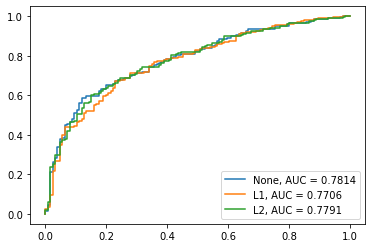

In [350]:
fpr, tpr, tresholds = roc_curve(y_test, y_predict_proba_lm[:,1])
plt.plot(fpr, tpr, label="None, AUC = %0.4f" % roc_auc_score(y_test, y_predict_proba_lm[:,1]))
fpr, tpr, tresholds = roc_curve(y_test, y_predict_proba_l1[:,1])
plt.plot(fpr, tpr, label="L1, AUC = %0.4f" % roc_auc_score(y_test, y_predict_proba_l1[:,1]))
fpr, tpr, tresholds = roc_curve(y_test, y_predict_proba_l2[:,1])
plt.plot(fpr, tpr, label="L2, AUC = %0.4f" % roc_auc_score(y_test, y_predict_proba_l2[:,1]))
plt.legend()

## Ocena które zmienne są mniej istotne

Bez regularyzacji:

In [781]:
column_names, i = X.columns, 0
print("Zmienne, które mają największy wpływ na model:")
for var in column_names:
    if lm.coef_[0][i] > 0.5 or lm.coef_[0][i] < -0.5:
        print(f"{var}: {lm.coef_[0][i]:0.4f}")
    i+=1
    

Zmienne, które mają największy wpływ na model:
purpose_new car: -0.6339
purpose_used car: 1.2374
checking_status_<0: -0.5089
checking_status_>=200: 0.7903
checking_status_no checking: 1.5614
credit_history_critical/other existing credit: 0.6977
savings_status_>=1000: 0.8082
savings_status_no known savings: 0.9526
employment_4<=X<7: 0.5531
personal_status_male single: 0.6182
other_parties_guarantor: 0.8496
other_payment_plans_none: 1.2145


L1:

In [798]:
lm_l1.fit(X_train, y_train)
column_names, i = X.columns, 0
print("Zmienne, które mają największy wpływ na model:")
for var in column_names:
    if lm_l1.coef_[0][i] > 0.8 or lm_l1.coef_[0][i] < -0.5:
        print(f"{var}: {lm_l1.coef_[0][i]:0.4f}")
    i+=1
    

Zmienne, które mają największy wpływ na model:
purpose_domestic appliance: 1.3686
purpose_new car: -0.5468
purpose_retraining: 3.1686
purpose_used car: 1.2086
checking_status_>=200: 1.0830
checking_status_no checking: 1.6816
credit_history_critical/other existing credit: 0.9189
credit_history_delayed previously: 0.9490
savings_status_>=1000: 2.0563
savings_status_no known savings: 1.0614
employment_unemployed: -0.5546
other_parties_guarantor: 1.4999
other_payment_plans_none: 1.1766
job_unemp/unskilled non res: 0.9477
foreign_worker_yes: -1.2827


In [799]:
column_names, i = X.columns, 0
print("Zmienne, które mają bardzo mały wpływ na model:")
for var in column_names:
    if lm.coef_[0][i] < 0.05 and lm.coef_[0][i] > -0.05:
        print(f"{var}: {lm.coef_[0][i]:0.4f}")
    i+=1

Zmienne, które mają bardzo mały wpływ na model:
duration: -0.0290
credit_amount: -0.0001
residence_since: 0.0388
age: 0.0301
purpose_radio/tv: 0.0142
credit_history_existing paid: 0.0066
property_magnitude_real estate: 0.0241


# 3.1 Model wektorów podpierających

### 3.1.1 Wykluczenie malo istotnych zmiennych kategorycznych

Po powyzszej macierzy korelacji widać ze pomiedzy tymi co zostaly jest juz mala korelacja, nic więcej nie usuwamy

### 3.1.2 Wykluczenie mało istotnych zmiennych numerycznych

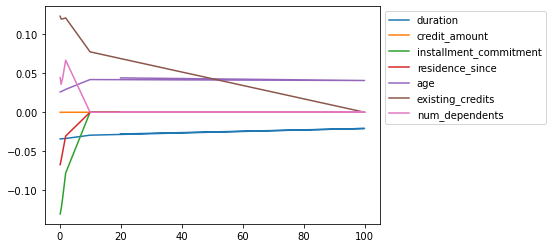

In [808]:
X_numbers = df.data[list(df.data.select_dtypes(include='number').columns)]
Xn_train, Xn_test, y_train, y_test = train_test_split(X_numbers, y, test_size = 0.3, random_state=320575)
C = np.array([5, 2, 1, 0.5, 0.1, 0.01, 0.05])
coefs = []
for i in C:
    lm_l1_i = LogisticRegression(penalty='l1', C=i, solver='liblinear')
    lm_l1_i.fit(Xn_train, y_train)
    coefs.append(lm_l1_i.coef_[0])
plt.plot(1/C, np.array(coefs), label = X_numbers.columns)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [801]:
column_names, i = X_numbers.columns, 0
Xn_train, Xn_test, y_train, y_test = train_test_split(X_numbers, y, test_size = 0.3, random_state=320575)
lm.fit(Xn_train, y_train)

print("--- Zmienne numeryczne wartosci wspolczynnikow:")

for var in column_names:
    print(f"{i+1}. {var}, | istotność: {lm.coef_[0][i]:0.5f}")
    i+=1

--- Zmienne numeryczne wartosci wspolczynnikow:
1. duration, | istotność: -0.02989
2. credit_amount, | istotność: -0.00002
3. installment_commitment, | istotność: 0.00117
4. residence_since, | istotność: 0.00254
5. age, | istotność: 0.04441
6. existing_credits, | istotność: 0.00225
7. num_dependents, | istotność: 0.00160


### 3.1.3 Sprawdzenie korelacji Pearsona dla trzech najsłabszych wyników ziennych

In [802]:
#from scipy.stats import pearsonr
for i in range(0, X_numbers.shape[1]):
    if X_numbers.columns[i] != "credit_amount":
        correlation_coefficient = pearsonr(X_numbers["credit_amount"], 
                                                    X_numbers.iloc[:,i])
        print(f"Współczynnik korelacji względem zmiennej [{X_numbers.columns[i]}] : {correlation_coefficient[0]:0.4f}")

Współczynnik korelacji względem zmiennej [duration] : 0.6250
Współczynnik korelacji względem zmiennej [installment_commitment] : -0.2713
Współczynnik korelacji względem zmiennej [residence_since] : 0.0289
Współczynnik korelacji względem zmiennej [age] : 0.0327
Współczynnik korelacji względem zmiennej [existing_credits] : 0.0208
Współczynnik korelacji względem zmiennej [num_dependents] : 0.0171


In [803]:
for i in range(0, X_numbers.shape[1]):
    if X_numbers.columns[i] != "num_dependents":
        correlation_coefficient = pearsonr(X_numbers["num_dependents"], 
                                                    X_numbers.iloc[:,i])
        print(f"Współczynnik korelacji względem zmiennej [{X_numbers.columns[i]}] : {correlation_coefficient[0]:0.4f}")

Współczynnik korelacji względem zmiennej [duration] : -0.0238
Współczynnik korelacji względem zmiennej [credit_amount] : 0.0171
Współczynnik korelacji względem zmiennej [installment_commitment] : -0.0712
Współczynnik korelacji względem zmiennej [residence_since] : 0.0426
Współczynnik korelacji względem zmiennej [age] : 0.1182
Współczynnik korelacji względem zmiennej [existing_credits] : 0.1097


In [804]:
from scipy.stats import pearsonr
for i in range(0, X_numbers.shape[1]):
    if X_numbers.columns[i] != "installment_commitment":
        correlation_coefficient = pearsonr(X_numbers["installment_commitment"], 
                                                    X_numbers.iloc[:,i])
        print(f'[{X_numbers.columns[i]}] Współczynnik korelacji Pearsona: {correlation_coefficient[0]:0.4f}')

[duration] Współczynnik korelacji Pearsona: 0.0747
[credit_amount] Współczynnik korelacji Pearsona: -0.2713
[residence_since] Współczynnik korelacji Pearsona: 0.0493
[age] Współczynnik korelacji Pearsona: 0.0583
[existing_credits] Współczynnik korelacji Pearsona: 0.0217
[num_dependents] Współczynnik korelacji Pearsona: -0.0712


Widzimy mocną korelację między amount a dwoma zmiennymi, ale słabą między czteroma zmiennymi. Nie odrzucamy tej zmiennej.
Podobnie installment_commitment oraz num_dependents nie powinny zostać odrzucone, bo mogą nieść korzystne informacje dla naszego modelu

len(lm.coef_)

In [860]:
lm = LogisticRegression(penalty=None, max_iter=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=320575)
lm.fit(X_train, y_train)
column_names, i = X_train.columns, 0
important_columns = []
max_val, second_val = "",""
first_max_ceof = np.abs(lm_l1.coef_).max()
second_max_coef = np.partition(np.abs(lm.coef_), -2)[:, -2]
print("--- Wazne zmienne to:")

for var in column_names:
    if lm.coef_[0][i] > 0.5 or lm.coef_[0][i] < -0.5:
        important_columns.append(var)
        print(f"{i}. {var}, | istotność: {lm.coef_[0][i]:0.2f}")
    if lm.coef_[0][i]==lm.coef_.max():
        max_val = var
    if lm.coef_[0][i]==second_max_coef:
        second_val = var
    i+=1

X_importat_categorical = X_train.loc[:, important_columns]
print(f"\nIlosc zmiennych: {len(important_columns)}")
print(f"Dwie najbardziej znaczące zmienne: {max_val}, {second_val}")

--- Wazne zmienne to:
10. purpose_new car, | istotność: -0.52
15. purpose_used car, | istotność: 1.56
17. checking_status_>=200, | istotność: 1.09
18. checking_status_no checking, | istotność: 1.74
19. credit_history_critical/other existing credit, | istotność: 0.72
25. savings_status_>=1000, | istotność: 1.23
26. savings_status_no known savings, | istotność: 1.07
27. employment_4<=X<7, | istotność: 0.59
32. personal_status_male mar/wid, | istotność: 0.56
33. personal_status_male single, | istotność: 0.67
34. other_parties_guarantor, | istotność: 1.44
39. other_payment_plans_none, | istotność: 0.91
41. housing_own, | istotność: 0.51
47. foreign_worker_yes, | istotność: -1.06

Ilosc zmiennych: 14
Dwie najbardziej znaczące zmienne: checking_status_no checking, purpose_used car


/Users/janpoglod/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0. purpose_domestic appliance, | istotność: -0.04
1. purpose_education, | istotność: -0.00
2. purpose_furniture/equipment, | istotność: -0.24
3. purpose_new car, | istotność: 0.07
4. purpose_other, | istotność: 0.02
5. purpose_radio/tv, | istotność: -0.24
6. purpose_repairs, | istotność: -0.21
7. purpose_retraining, | istotność: 0.30
8. purpose_used car, | istotność: -0.43
9. checking_status_<0, | istotność: 0.19
10. checking_status_>=200, | istotność: -0.52
11. checking_status_no checking, | istotność: -0.13
12. credit_history_critical/other existing credit, | istotność: 0.17
13. credit_history_delayed previously, | istotność: -0.24
14. credit_history_existing paid, | istotność: 0.29
15. credit_history_no credits/all paid, | istotność: 1.56
16. savings_status_500<=X<1000, | istotność: -0.39
17. savings_status_<100, | istotność: 1.09
18. savings_status_>=1000, | istotność: 1.74
19. savings_status_no known savings, | istotność: 0.72
20. employment_4<=X<7, | istotność: 0.49
21. employmen

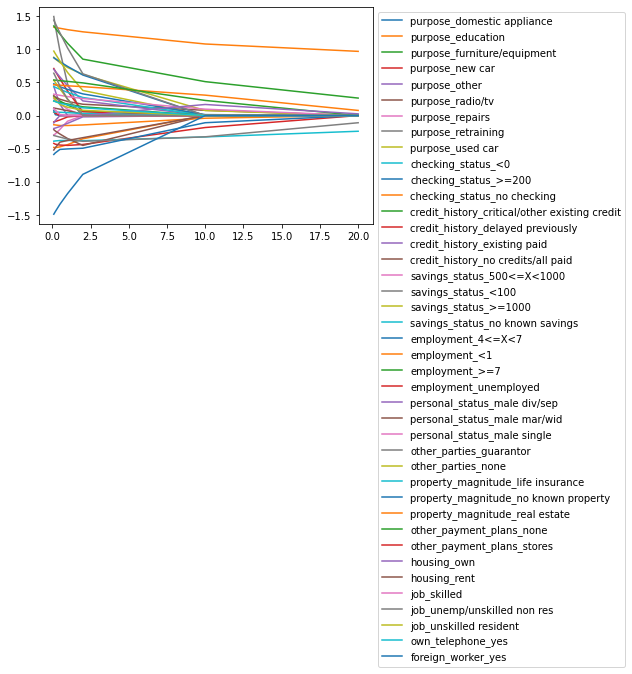

In [861]:
# mniej wpływowe zmienne
X_less_importat_categorical = X.drop(important_columns, axis=1)
X_less_importat_categorical = X.drop(["duration","credit_amount","age","installment_commitment","residence_since","existing_credits","num_dependents"], axis=1)
column_names2, i = X_less_importat_categorical.columns, 0
LESS_important_columns = []
for var in column_names2:
    if lm.coef_[0][i] < 0.01 or lm.coef_[0][i] > -0.01:
        LESS_important_columns.append(var)
        print(f"{i}. {var}, | istotność: {lm.coef_[0][i]:0.2f}")
        i+=1
C = np.array([10, 5, 2, 1, 0.5, 0.1, 0.05])
coefs = []
for i in C:
    lm_l1_i = LogisticRegression(penalty='l1', C=i, solver='saga', max_iter=10000)
    lm_l1_i.fit(X_less_importat_categorical, y)
    coefs.append(lm_l1_i.coef_[0])
plt.plot(1/C, np.array(coefs), label = X_less_importat_categorical.columns)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

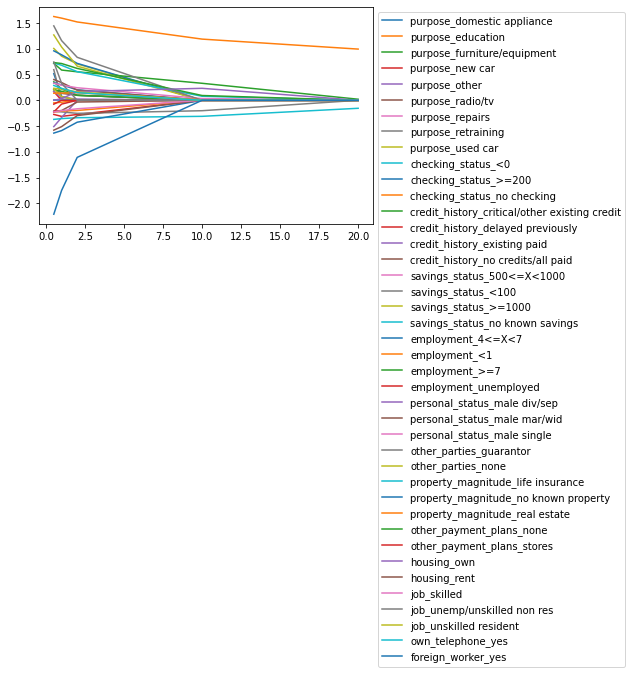

In [862]:
C = np.array([2, 1, 0.5, 0.1, 0.05])
X_train_search= X_train.drop(["duration","credit_amount","age","installment_commitment","residence_since","existing_credits","num_dependents"], axis=1)
coefs = []
for i in C:
    lm_l1_i = LogisticRegression(penalty='l1', C=i, solver='saga', max_iter=10000)
    lm_l1_i.fit(X_train_search, y_train)
    coefs.append(lm_l1_i.coef_[0])
plt.plot(1/C, np.array(coefs), label = X_train_search.columns)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [863]:
lm_l1_searched = LogisticRegression(penalty='l1', C=0.5, solver='saga', max_iter=10000)
lm_l1_searched.fit(X_train_search, y_train)
n = len(np.array(lm_l1_searched.coef_[0]))
searched_important_values = []
for i in range(n):
    if np.array(lm_l1_searched.coef_)[0][i] > 0:
        searched_important_values.append(X.columns[i])

# zbudowanie modelu na podstawie tych zmiennych

lm_l1_new = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X[searched_important_values], y, test_size = 0.3, random_state=320575)
lm_l1_new.fit(X_train_new, y_train_new)

i=0
for var in searched_important_values:
    print(f"{i}. {var}, | istotność: {lm_l1_new.coef_[0][i]:0.2f}")
    i+=1

X_new = X[searched_important_values]


0. installment_commitment, | istotność: -0.15
1. existing_credits, | istotność: -0.12
2. purpose_education, | istotność: -0.49
3. purpose_new car, | istotność: -0.39
4. purpose_other, | istotność: -0.20
5. purpose_radio/tv, | istotność: 0.12
6. purpose_retraining, | istotność: 0.00
7. checking_status_no checking, | istotność: 1.75
8. credit_history_critical/other existing credit, | istotność: 0.82
9. credit_history_delayed previously, | istotność: 0.04
10. credit_history_no credits/all paid, | istotność: -0.16
11. savings_status_>=1000, | istotność: 1.15
12. savings_status_no known savings, | istotność: 0.94
13. employment_4<=X<7, | istotność: 0.27
14. personal_status_male div/sep, | istotność: -0.14
15. personal_status_male mar/wid, | istotność: 0.13
16. other_parties_guarantor, | istotność: 0.95
17. property_magnitude_real estate, | istotność: 0.26
18. other_payment_plans_none, | istotność: 0.56


In [858]:
lm_l1_searched = LogisticRegression(penalty='l1', C=0.5, solver='saga', max_iter=10000)
lm_l1_searched.fit(X_train_search, y_train)
n = len(np.array(lm_l1_searched.coef_[0]))
searched_important_values = []
for i in range(n):
    if np.array(lm_l1_searched.coef_)[0][i] > 0:
        searched_important_values.append(X.columns[i])

# zbudowanie modelu na podstawie tych zmiennych

lm_l1_new = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X[searched_important_values], y, test_size = 0.3, random_state=320575)
lm_l1_new.fit(X_train_new, y_train_new)

i=0
for var in searched_important_values:
    print(f"{i}. {var}, | istotność: {lm_l1_new.coef_[0][i]:0.2f}")
    i+=1

X_new = X[searched_important_values]


0. residence_since, | istotność: -0.06
1. num_dependents, | istotność: 0.12
2. credit_history_critical/other existing credit, | istotność: 1.25
3. credit_history_existing paid, | istotność: 0.42
4. savings_status_500<=X<1000, | istotność: 0.00
5. savings_status_<100, | istotność: -0.79
6. personal_status_male div/sep, | istotność: -0.21
7. personal_status_male mar/wid, | istotność: 0.03


In [864]:
from scipy.stats import ttest_ind
# purpose_retraining
t_statistic, p_value = ttest_ind(X_new['purpose_retraining'], X_new['purpose_other'])
print("Wartość p-value:", p_value)

Wartość p-value: 0.5107038784363993


In [865]:
# credit_history_no credits/all paid
t_statistic, p_value = ttest_ind(X_new['savings_status_>=1000'], X_new['credit_history_no credits/all paid'])
print("Wartość p-value:", p_value)

Wartość p-value: 0.38334756060299935


In [866]:
# credit_history_delayed previously
t_statistic, p_value = ttest_ind(X_new['credit_history_delayed previously'], X_new['personal_status_male mar/wid'])
print("Wartość p-value:", p_value)

Wartość p-value: 0.7547771472615411


In [867]:
X_importat_categorical = X_new.drop(["credit_history_delayed previously","credit_history_no credits/all paid","purpose_retraining"], axis=1)

## 3.1.4 Brak decyzji o odrzuceniu jakiejkolwiek zmiennej numerycznej

### Połączenie ramki z danymi numerycznymi i wybranymi danymi kategorycznymi

In [868]:
X_merge = pd.concat([X_numbers,X_importat_categorical], axis=1)
X_merge.shape

(1000, 23)

In [869]:
Xnew_train, Xnew_test, y_train, y_test = train_test_split(X_merge, y, test_size=0.3, random_state=42)
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
svm_linear = SVC(C=0.001, kernel = 'linear')
svm_linear.fit(Xnew_train, y_train)
y_pred = svm_linear.predict(Xnew_test)
print(f"accuracy_score = {accuracy_score(y_test, y_pred):0.4f}")

accuracy_score = 0.6967


Optymalizacja parametru C

In [465]:
import sklearn.model_selection as skm
kfold = skm.KFold(3,
                  random_state=0,
                  shuffle=True)
grid = skm.GridSearchCV(svm_linear,
                        {'C':[0.001, 0.01, 0.1, 1, 5, 10]},
                         refit=True,
                         cv=kfold,
                         scoring='accuracy')
grid.fit(Xnew_train, y_train)
print(f"Best params: {grid.best_params_}")
print(f"Mean test score: {grid.cv_results_[('mean_test_score')]}")
grid.best_estimator_

Best params: {'C': 5}
Mean test score: [0.70147219 0.70147219 0.74571733 0.73574582 0.74862747 0.73288458]


SVC(C=5, kernel='linear')

AUC = 0.7645512382354488
accuracy_score = 0.7367
accuracy_score = 0.7778
accuracy_score = 0.8708


/Users/janpoglod/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


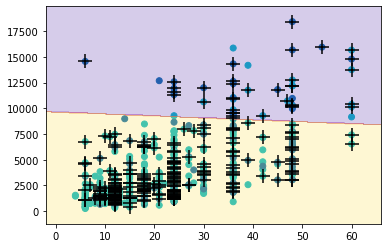

In [872]:
svm_linear_first = SVC(C=5, kernel = 'linear', probability=True)
svm_linear_first.fit(Xnew_train, y_train)
y_pred_first = svm_linear_first.predict(Xnew_test)
y_pred_proba_first = svm_linear_first.predict_proba(Xnew_test)
print(f"AUC = {roc_auc_score(y_test, y_pred_proba_first[:,1])}")
print(f"accuracy_score = {accuracy_score(y_test, y_pred_first):0.4f}")
print(f"accuracy_score = {precision_score(y_test, y_pred_first):0.4f}")
print(f"accuracy_score = {recall_score(y_test, y_pred_first):0.4f}")
fig, ax = plt.subplots()
plot_svm(Xnew_train, y_train, svm_linear_first, ax=ax)

## Model 2

In [843]:
lm = LogisticRegression(penalty=None, max_iter=1000)
X_numbers_columns = df.data[list(df.data.select_dtypes(include='number').columns)].columns
X_m2 = X.drop(X_numbers_columns, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=320575)
lm.fit(X_train, y_train)
column_names, i = X_train.columns, 0
less_important_columns = []
max_val, second_val = "",""
print("--- Wazne zmienne to:")

for var in column_names:
    if lm.coef_[0][i] > -0.5 and lm.coef_[0][i] < 0.5:
        less_important_columns.append(var)
        print(f"{i}. {var}, | istotność: {lm.coef_[0][i]:0.2f}")
    if lm.coef_[0][i]==lm.coef_.max():
        max_val = var
    if lm.coef_[0][i]==second_max_coef:
        second_val = var
    i+=1

print(f"\nIlosc zmiennych: {len(less_important_columns)}")
X_m2 = X.drop(less_important_columns, axis =1)
X_merge = pd.concat([X_numbers,X_m2], axis=1)
X_merge.shape

--- Wazne zmienne to:
0. duration, | istotność: -0.03
1. credit_amount, | istotność: -0.00
2. installment_commitment, | istotność: -0.26
3. residence_since, | istotność: 0.04
4. age, | istotność: 0.03
5. existing_credits, | istotność: -0.12
6. num_dependents, | istotność: -0.16
7. purpose_domestic appliance, | istotność: 0.23
8. purpose_education, | istotność: -0.34
9. purpose_furniture/equipment, | istotność: 0.23
11. purpose_other, | istotność: -0.13
12. purpose_radio/tv, | istotność: 0.01
13. purpose_repairs, | istotność: -0.14
14. purpose_retraining, | istotność: 0.24
20. credit_history_delayed previously, | istotność: 0.42
21. credit_history_existing paid, | istotność: 0.01
22. credit_history_no credits/all paid, | istotność: -0.23
23. savings_status_500<=X<1000, | istotność: -0.34
24. savings_status_<100, | istotność: -0.18
28. employment_<1, | istotność: -0.31
29. employment_>=7, | istotność: -0.14
30. employment_unemployed, | istotność: -0.28
31. personal_status_male div/sep, |

(1000, 19)

accuracy_score = 0.7733
accuracy_score = 0.8133
accuracy_score = 0.8756


/Users/janpoglod/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


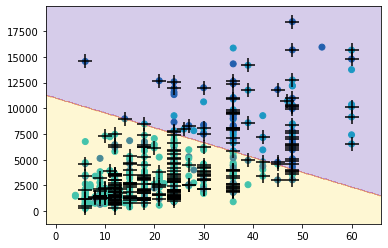

In [853]:
Xnew_train, Xnew_test, y_train, y_test = train_test_split(X_merge, y, test_size=0.3, random_state=42)
svm_linear = SVC(C=1, kernel = 'linear', probability=True)
svm_linear.fit(Xnew_train, y_train)
y_pred = svm_linear.predict(Xnew_test)
y_pred_proba = svm_linear.predict_proba(Xnew_test)
print(f"accuracy_score = {accuracy_score(y_test, y_pred):0.4f}")
print(f"accuracy_score = {precision_score(y_test, y_pred):0.4f}")
print(f"accuracy_score = {recall_score(y_test, y_pred):0.4f}")
fig, ax = plt.subplots()
plot_svm(Xnew_train, y_train, svm_linear, ax=ax)

AUC = 0.8213365581786635


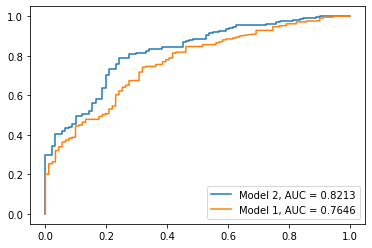

In [874]:
print(f"AUC = {roc_auc_score(y_test, y_pred_proba[:,1])}")
fpr, tpr, tresholds = roc_curve(y_test, y_pred_proba[:,1])
plt.plot(fpr, tpr, label="Model 2, AUC = %0.4f" % roc_auc_score(y_test, y_pred_proba[:,1]))
fpr, tpr, tresholds = roc_curve(y_test, y_pred_proba_first[:,1])
plt.plot(fpr, tpr, label="Model 1, AUC = %0.4f" % roc_auc_score(y_test, y_pred_proba_first[:,1]))
plt.legend()

In [ ]:
fpr, tpr, tresholds = roc_curve(y_test, y_pred_proba[:,1])
plt.plot(fpr, tpr, label="None, AUC = %0.4f" % roc_auc_score(y_test, y_pred_proba[:,1]))

accuracy_score = 0.7700
accuracy_score = 0.8241
accuracy_score = 0.8517


/Users/janpoglod/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


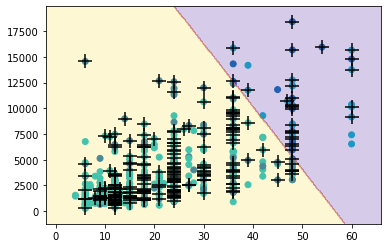

In [846]:
svm_linear = SVC(C=10, kernel = 'linear')
svm_linear.fit(Xnew_train, y_train)
y_pred = svm_linear.predict(Xnew_test)
print(f"accuracy_score = {accuracy_score(y_test, y_pred):0.4f}")
print(f"accuracy_score = {precision_score(y_test, y_pred):0.4f}")
print(f"accuracy_score = {recall_score(y_test, y_pred):0.4f}")
fig, ax = plt.subplots()
plot_svm(Xnew_train, y_train, svm_linear, ax=ax)

accuracy_score = 0.7567
accuracy_score = 0.8119
accuracy_score = 0.8469


/Users/janpoglod/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


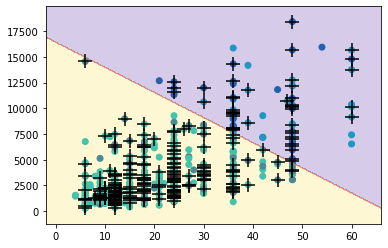

In [847]:
svm_linear = SVC(C=5, kernel = 'linear')
svm_linear.fit(Xnew_train, y_train)
y_pred = svm_linear.predict(Xnew_test)
print(f"accuracy_score = {accuracy_score(y_test, y_pred):0.4f}")
print(f"accuracy_score = {precision_score(y_test, y_pred):0.4f}")
print(f"accuracy_score = {recall_score(y_test, y_pred):0.4f}")
fig, ax = plt.subplots()
plot_svm(Xnew_train, y_train, svm_linear, ax=ax)

### Wyniki na treningowym

In [880]:
y_pred_end1 = svm_linear_first.predict(Xnew_train)
y_predict_proba_end1 = svm_linear_first.predict_proba(Xnew_train)
print("Model 1 po regularyzacji:\n")
print("Accuracy score: %0.4f\nRecall score: %0.4f\nRoc Auc score: %0.4f" % (accuracy_score(y_train, y_pred_end1), recall_score(y_train, y_pred_end1), roc_auc_score(y_train, y_predict_proba_end1[:,1])))
print(f"Precision Score = {np.round(precision_score(y_train, y_pred_end1),4)}")

Model 1 po regularyzacji:

Accuracy score: 0.7514
Recall score: 0.8798
Roc Auc score: 0.7826
Precision Score = 0.7898
